In [1]:
from datetime import datetime
import os
import time
import requests
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import doctor
import math
from IPython.display import clear_output
import main
import seaborn as sea
import matplotlib.patches as patches
import matplotlib as mpl

In [2]:
aba = main.Abathor('LTC-USD')

### Open

In [3]:
def plot_candles(candles, signal, fig, ax):
    def add_rectangle(i, open_, close,low, high, ax, sig):
        x = i - .5
        y = min(open_, close)
        height = abs(open_ - close)
        if sig == 'buy':
            color = 'green'
            hatch = 'x'
        if sig == 'sell':
            color = 'red'
            hatch = ''
            
        if sig == 'wait':
            color = 'orange'
            hatch = ''
        ax.add_patch(patches.Rectangle((x, y), .9, height,
                                       fill = open_ <= close, facecolor = color,
                                       edgecolor = color, hatch = hatch ))
        top = max(open_,close)
        bottom = min(open_,close)

        if low < bottom:
            ax.add_line(mpl.lines.Line2D([i,i], [low, bottom], color = color) )

            
        if high > top:
            ax.add_line(mpl.lines.Line2D([i,i], [high, top], color = color) )

        
    for i, index in enumerate(candles.index):
        sig = signal.loc[index]
        row = candles.loc[index]
        add_rectangle(i, row['open'], row['close'],row['low'], row['high'],  ax, sig)
    ax.set_xlim(0, len(candles))
    ax.set_ylim(candles['close'].min() *.998, candles['close'].max() * 1.002)
    return ax

In [4]:
def chartio(gran, count):
    cans = aba.get_candles(granularity= gran)
    mask = cans['open']< cans['close']
    signal = pd.Series(index = cans.index )
    signal.loc[mask] = 'buy'
    signal.loc[~mask] = 'sell'
    
    fig, (ax, sig_ax) = plt.subplots(nrows = 2, sharex= False)
    fig.set_size_inches(7, 9)
    plot_candles(cans[-count:], signal[-count:], fig, ax)
    ax.set_xticklabels(cans.index)
    ax2 = ax.twinx()
    cans.iloc[-count:]['volume'].plot(kind = 'bar', ax = ax2, alpha = 0.3)

    
    rsi = aba.get_rsi(cans['close'])
    macd = aba.get_macd(cans)
    rsi.plot(ax = sig_ax, alpha = 0.1)
    ax4 = sig_ax.twinx()
    macd[['macd', 'macd_signal']].plot(ax = ax4)
    plt.show()
    

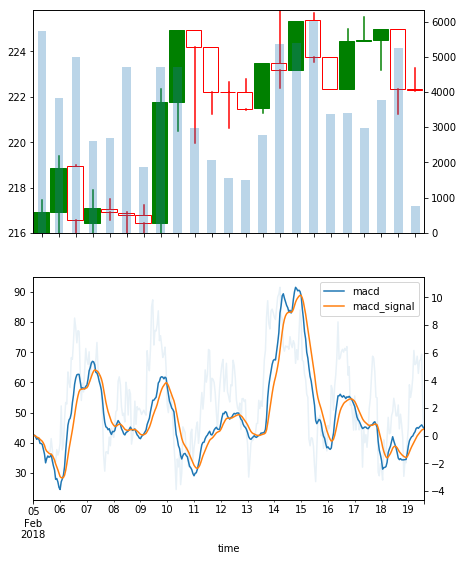

In [42]:
chartio( 60 * 60, 23)

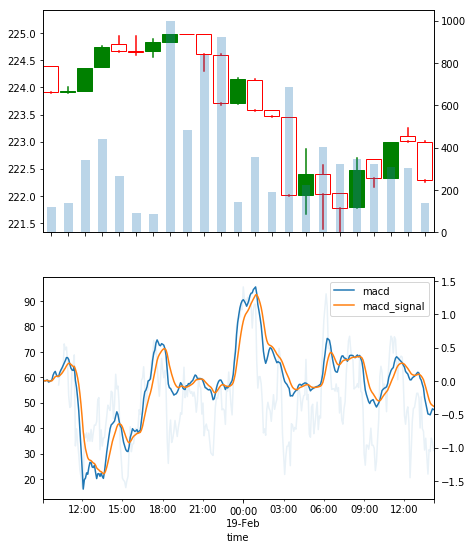

In [43]:
chartio( 60 *5, 23)

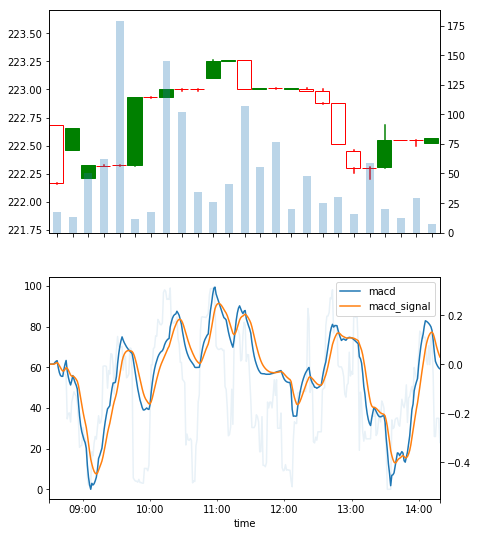

In [59]:
chartio( 60, 25)

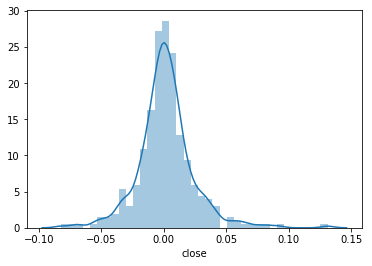

count    178.000000
mean       0.016983
std        0.018658
min        0.000045
25%        0.005357
50%        0.010809
75%        0.022338
max        0.131225
Name: close, dtype: float64
count    171.000000
mean      -0.014469
std        0.014808
min       -0.082361
25%       -0.018886
50%       -0.010152
75%       -0.004108
max       -0.000044
Name: close, dtype: float64


In [146]:
cans = aba.get_candles(granularity= 60* 60)
sea.distplot(cans['close'].pct_change().fillna(0))
plt.show()

changes = cans['close'].pct_change()
up = changes[changes >0]
down = changes[changes <0]

print(up.describe())
print(down.describe())

In [144]:
aba.place_sell(224.69, 'limit')

{'status': 'Nothing to sell'}

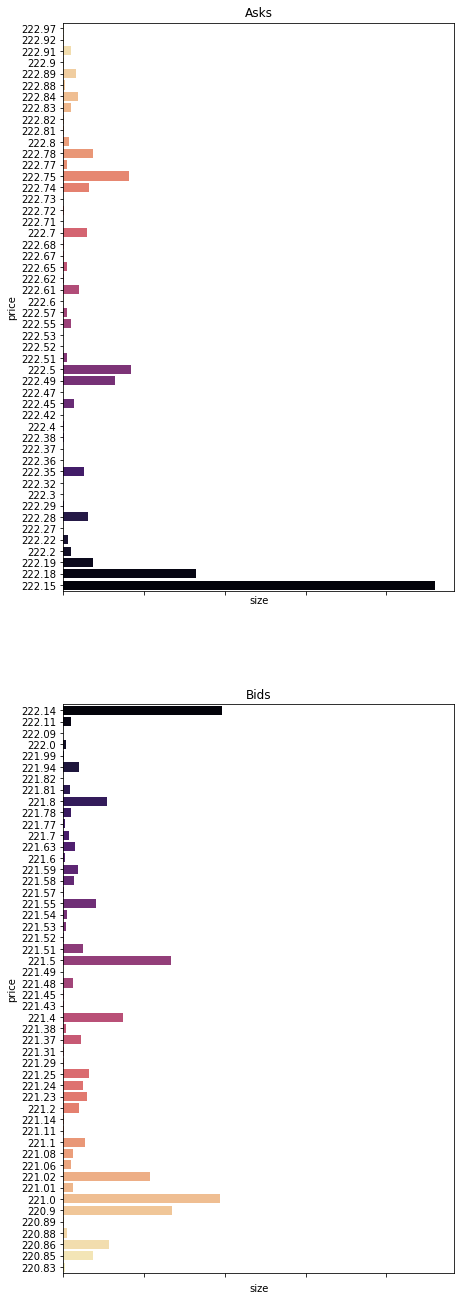

asks
              size  count
price                    
222.75   81.000000      5
222.50   84.171768      6
222.15  460.646896     17
bids
              size  count
price                    
222.14  196.756561      9
221.00  194.337779     18


In [243]:
bids, asks = aba.get_book(2)
asks.sort_index(inplace=True, ascending = False)
bids.sort_index(inplace = True, ascending=False)
fig, (ax,ax2) = plt.subplots(2, sharex= True)
fig.set_size_inches(7, 23)

sea.barplot(asks['size'], asks.index,order = asks.index, palette= 'magma_r', orient = 'h', ax = ax)
ax.set_title('Asks')


ax2.set_title('Bids')
sea.barplot(bids['size'], bids.index,order = bids.index, palette= 'magma', orient = 'h', ax = ax2)
ax2.set_xticklabels(ax.get_xticklabels(), rotation = 90 * 3)
plt.subplots_adjust(wspace=None, hspace=None)
plt.show()

print('asks')
print(asks[asks['count'] >= asks['count'].std()*2])
print('bids')
print(bids[bids['count'] >= bids['count'].std()*2])

In [258]:
def play_trade(lower_range, upper_range, target):
    assert( lower_range < upper_range)
    assert(target > upper_range * 1.003)

    def get_location(lower_range, upper_range):
        best_bid, best_ask = aba.get_book()
        best_bid = best_bid.index[0]
        best_ask = best_ask.index[0]
        if best_bid > upper_range:
            return 'above', best_bid , best_ask
        if best_ask < upper_range:
            return 'below', best_bid , best_ask
        return 'between', best_bid, best_ask
    
    
    i = 0
    status = 'pre-entry'
    while True:
        i = i + 1
        location, bid, ask = get_location(lower_range, upper_range)
        
        print('Bid {} - Ask {} - Iteration: {}'.format(bid, ask, i ))
        print(location)
        
        if location == 'above':
            if status == 'pre-entry':
                aba.place_buy(upper_range + 0.01, 'market')
                status = 'buy_order_placed'
                
            if status == 'buy_order_placed':
                if len(aba.get_open_orders() == 0):
                    aba.place_sell(target)
                    status = 'sell_order_placed'
            
            if status == 'sell_order_placed':
                if len(aba.get_open_orders()) == 0:
                    return 'Win'
                
        if location == 'below':
            if status == 'pre-entry':
                return 'Broke Down'
            if 'order_placed' in status:
                aba.cancel_all()
                aba.place_sell(bid, 'market')
                return 'Broke Down'
        
            
            
        clear_output(True)

In [ ]:
play_trade(221.77, 221.78, 222.45)

Bid 221.77 - Ask 221.78 - Iteration: 2
between
